# IBM Instance Setup

In [1]:
%cd ..

/Users/uribagi/Documents/GitHub/Latent-IQP


In [2]:
from dotenv import load_dotenv
import os
import jax
import jax.numpy as jnp

key = jax.random.PRNGKey(42)

In [3]:
load_dotenv('.env')

ibm_token = os.getenv('IBM_TOKEN')
instance = os.getenv("INSTANCE")

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session

In [5]:
setup = False

if setup:
    QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True)

In [6]:
service = QiskitRuntimeService(channel="ibm_cloud", token = ibm_token, instance=instance)

In [7]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=156)
print(backend)

<IBMBackend('ibm_aachen')>


In [8]:
import pennylane as qml

dev = qml.device('qiskit.remote', 
                    wires=backend.num_qubits, 
                    backend=backend, 
                    shots=1024,
                    optimization_level=3)

# IQP Setup (with training)

In [9]:
import iqpopt as iqp
from iqpopt.utils import initialize_from_data, local_gates
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
from utils.nisq import create_grid_connectivity_manual, efficient_connectivity_gates

In [10]:
nodes = 10

In [11]:
grid_conn = create_grid_connectivity_manual()
num_qubits = nodes * (nodes - 1) // 2
gates = efficient_connectivity_gates(grid_conn, num_qubits, 1)

In [12]:
len(gates)

92

In [13]:
circ = iqp.IqpSimulator(num_qubits, gates, device='lightning.qubit')

# Dataset

In [14]:
from datasets.bipartites import BipartiteGraphDataset

In [15]:
dataset = BipartiteGraphDataset(num_samples=1024,
                                num_vertices=nodes,
                                ratio_bipartite=1.0,
                                edge_prob=0.2)


Bipartite Dataset (k=10, p=0.2, connected=True):
Target samples: 1024, Generated samples: 1024
Bipartite: 1024, Non-Bipartite: 0
Target Ratio (Bipartite): 1.000, Actual Ratio: 1.000


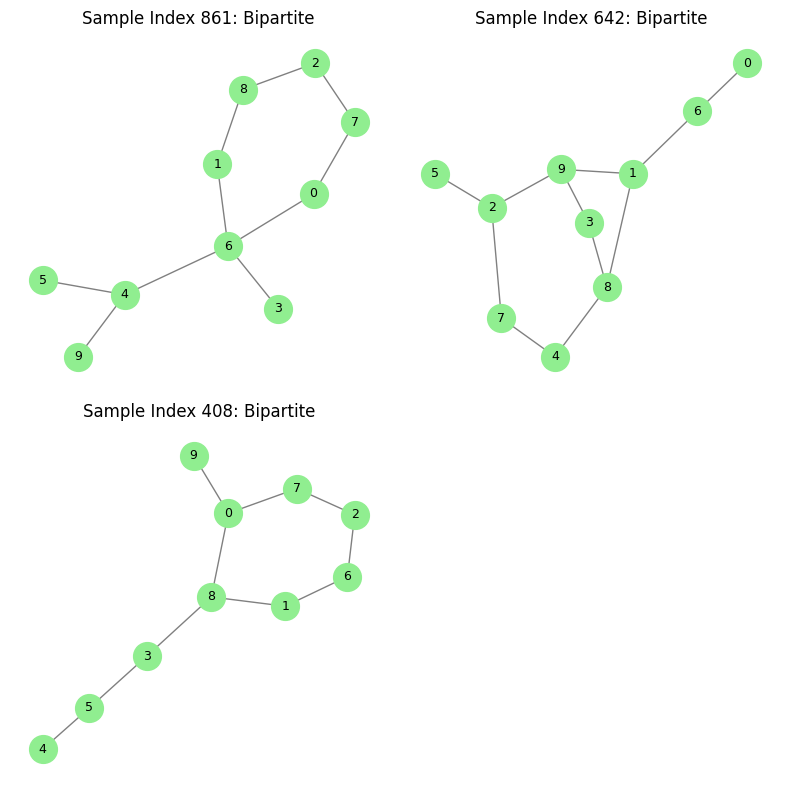

In [16]:
dataset.plot_random_samples(num_samples_to_plot=3)

In [17]:
train_ds, _ = dataset.get_all_data()

In [ ]:
SIGMA_MULTIPLIER = 1.9666857648128913
INIT_MULTIPLIER = 0.0003543470455562567
LEARNING_RATE = 0.009172089519608987

In [19]:
sigma = median_heuristic(train_ds) * SIGMA_MULTIPLIER
params_init = initialize_from_data(gates, jnp.array(train_ds)) * INIT_MULTIPLIER

In [20]:
loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(train_ds),
    "sigma": [sigma],
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),
}

In [21]:
loss = genq.mmd_loss_iqp

trainer = iqp.Trainer("Adam", loss, stepsize=LEARNING_RATE)
trainer.train(n_iters= 2500,loss_kwargs=loss_kwarg, turbo=1)

Training Progress: 100%|██████████| 2000/2000 [00:31<00:00, 63.06it/s, loss=-0.000034, elapsed time=0.01, total time=32.4]


Training has not converged after 2000 steps


In [22]:
trained_params = trainer.final_params

In [23]:
from datasets.utils import is_bipartite

In [24]:
if num_qubits < 25:
    samples = circ.sample(trained_params, shots =1024)
    total = 0
    for sample in samples:
        if is_bipartite(sample, nodes):
            total += 1

    print(total, " out of ", 1024, "correct")

# Hardware test

In [25]:
import numpy as np
@qml.qnode(dev)
def sample():
    IPQ = circ.iqp_circuit(np.asarray(trained_params))
    return qml.sample(wires = range(num_qubits))

In [26]:
with Session(backend=backend, max_time="2h") as session:
    result = sample()

In [27]:
total = 0
for sample in result:
    if is_bipartite(sample, nodes):
        total += 1

print(total, " out of ", 1024, "correct")

618  out of  1024 correct


In [28]:
prob = 0
for sample in result:
    prob += sum(sample)/num_qubits

In [29]:
print(len(result[0]))

45


In [30]:
prob/len(result)

np.float64(0.2449869791666674)